In [ ]:
import pandas as pd


df = pd.read_csv('/content/news_dataset.csv')


print("Missing values per column:\n", df[['text', 'label']].isnull().sum())


df_cleaned = df.dropna(subset=['text', 'label'])

print("\nAfter handling missing values:")
print(df_cleaned.head())


Missing values per column:
 text     8
label    0
dtype: int64

After handling missing values:
  label                                               text
0  REAL  Payal has accused filmmaker Anurag Kashyap of ...
1  FAKE  A four-minute-long video of a woman criticisin...
2  FAKE  Republic Poll, a fake Twitter account imitatin...
3  REAL  Delhi teen finds place on UN green list, turns...
4  REAL  Delhi: A high-level meeting underway at reside...


In [ ]:
import string
import re
from nltk.corpus import stopwords
import nltk


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):

    text = text.lower()

    text = re.sub(r'http\S+', '', text)

    text = re.sub(r'[^a-z\s]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply text cleaning
df_cleaned['cleaned_text'] = df_cleaned['text'].apply(clean_text)

print("\nSample of cleaned text:")
print(df_cleaned[['text', 'cleaned_text']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Sample of cleaned text:
                                                text  \
0  Payal has accused filmmaker Anurag Kashyap of ...   
1  A four-minute-long video of a woman criticisin...   
2  Republic Poll, a fake Twitter account imitatin...   
3  Delhi teen finds place on UN green list, turns...   
4  Delhi: A high-level meeting underway at reside...   

                                        cleaned_text  
0  payal accused filmmaker anurag kashyap behavin...  
1  fourminutelong video woman criticising governm...  
2  republic poll fake twitter account imitating a...  
3  delhi teen finds place un green list turns gla...  
4  delhi highlevel meeting underway residence raj...  


<ipython-input-14-40533af0c71b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned_text'] = df_cleaned['text'].apply(clean_text)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(max_features=5000)


tfidf_matrix = tfidf_vectorizer.fit_transform(df_cleaned['cleaned_text'])

print(f"\nTF-IDF matrix shape: {tfidf_matrix.shape}")



TF-IDF matrix shape: (3721, 5000)


In [ ]:
from textblob import TextBlob


df_cleaned['word_count'] = df_cleaned['text'].apply(lambda x: len(x.split()))


df_cleaned['char_count'] = df_cleaned['text'].apply(len)


df_cleaned['sentiment_score'] = df_cleaned['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

print("\nSample of engineered features:")
print(df_cleaned[['word_count', 'char_count', 'sentiment_score']].head())


<ipython-input-16-e94fb4bcbaec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['word_count'] = df_cleaned['text'].apply(lambda x: len(x.split()))
<ipython-input-16-e94fb4bcbaec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['char_count'] = df_cleaned['text'].apply(len)



Sample of engineered features:
   word_count  char_count  sentiment_score
0          97         538         0.150000
1         583        3406        -0.138393
2         490        3084        -0.075510
3         387        2383         0.129851
4         891        5572         0.013792


<ipython-input-16-e94fb4bcbaec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['sentiment_score'] = df_cleaned['text'].apply(lambda x: TextBlob(x).sentiment.polarity)


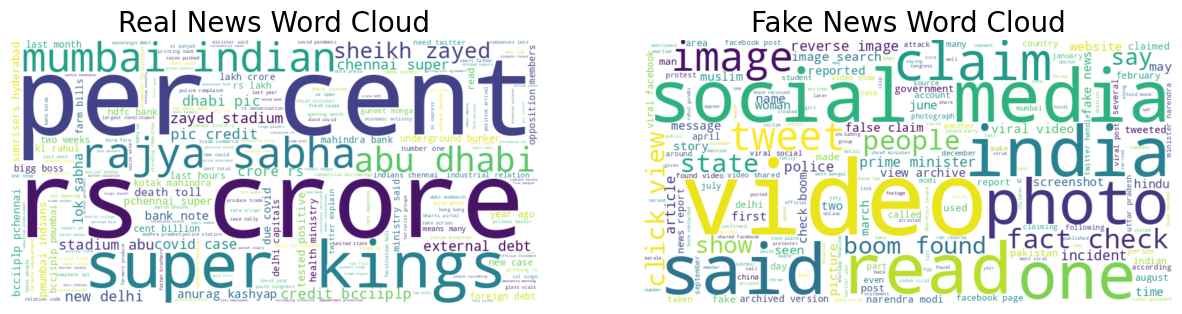

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


real_news = df_cleaned[df_cleaned['label'].str.lower() == 'real']['cleaned_text']
fake_news = df_cleaned[df_cleaned['label'].str.lower() == 'fake']['cleaned_text']


real_text = ' '.join(real_news)
fake_text = ' '.join(fake_news)


real_wc = WordCloud(width=800, height=400, background_color='white').generate(real_text)
fake_wc = WordCloud(width=800, height=400, background_color='white').generate(fake_text)


plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(real_wc, interpolation='bilinear')
plt.title('Real News Word Cloud', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fake_wc, interpolation='bilinear')
plt.title('Fake News Word Cloud', fontsize=20)
plt.axis('off')

plt.show()


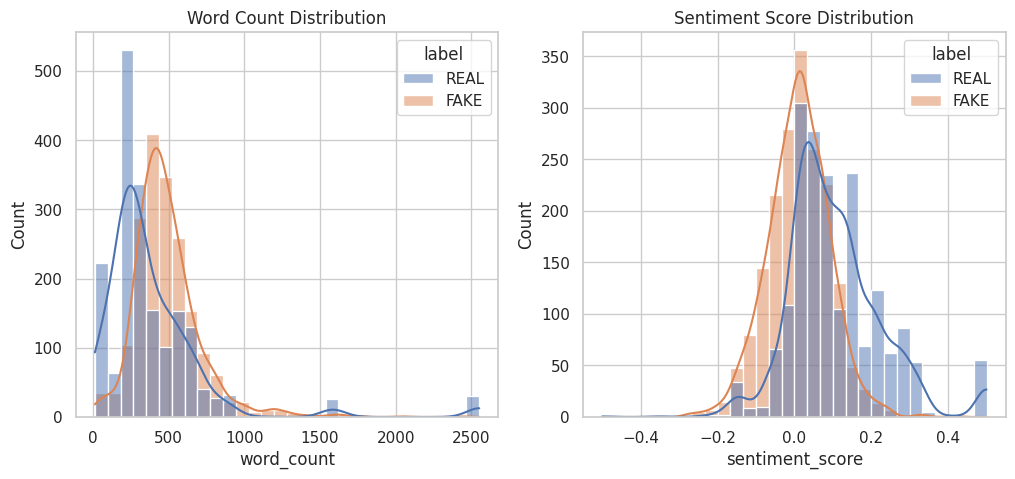

In [ ]:
import seaborn as sns


sns.set(style='whitegrid')


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df_cleaned, x='word_count', hue='label', bins=30, kde=True)
plt.title('Word Count Distribution')


plt.subplot(1, 2, 2)
sns.histplot(data=df_cleaned, x='sentiment_score', hue='label', bins=30, kde=True)
plt.title('Sentiment Score Distribution')

plt.show()


<ipython-input-19-06a473bb21e7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned, x='label', palette='viridis')


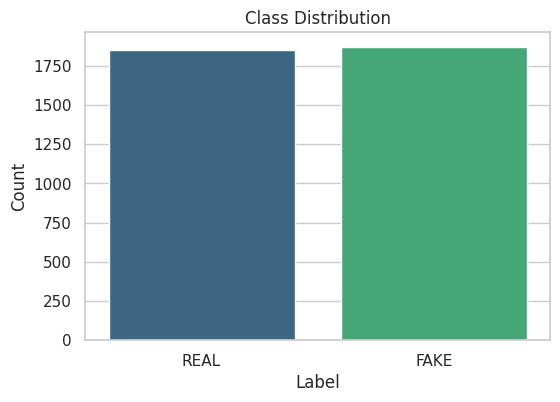


Class counts:
label
FAKE    1871
REAL    1850
Name: count, dtype: int64


In [ ]:

plt.figure(figsize=(6,4))
sns.countplot(data=df_cleaned, x='label', palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


print("\nClass counts:")
print(df_cleaned['label'].value_counts())


In [ ]:
from imblearn.over_sampling import SMOTE

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(df_cleaned['label'])

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(tfidf_matrix, y_encoded)

print(f"\nAfter SMOTE, counts of label '1': {sum(y_resampled==1)}")
print(f"After SMOTE, counts of label '0': {sum(y_resampled==0)}")



After SMOTE, counts of label '1': 1871
After SMOTE, counts of label '0': 1871


In [ ]:
from sklearn.model_selection import train_test_split

# Define target variable
y = y_resampled  # Use y_encoded if not using SMOTE

# Define features
X = X_resampled  # Use tfidf_matrix if not using SMOTE

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")



Training set shape: (2993, 5000)
Testing set shape: (749, 5000)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Function to print classification report
def print_classification_report(y_true, y_pred, model_name):
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Logistic Regression
print_classification_report(y_test, y_pred_logreg, "Logistic Regression")

# Naive Bayes
print_classification_report(y_test, y_pred_nb, "Naive Bayes")

# Random Forest
print_classification_report(y_test, y_pred_rf, "Random Forest")



Classification Report for Logistic Regression:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99       375
        Real       0.99      0.99      0.99       374

    accuracy                           0.99       749
   macro avg       0.99      0.99      0.99       749
weighted avg       0.99      0.99      0.99       749


Classification Report for Naive Bayes:
              precision    recall  f1-score   support

        Fake       0.91      1.00      0.95       375
        Real       1.00      0.90      0.94       374

    accuracy                           0.95       749
   macro avg       0.95      0.95      0.95       749
weighted avg       0.95      0.95      0.95       749


Classification Report for Random Forest:
              precision    recall  f1-score   support

        Fake       0.99      1.00      1.00       375
        Real       1.00      0.99      1.00       374

    accuracy                           1.00       74

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
print(f"\nBest Parameters: {grid_search.best_params_}")

# Best estimator
best_rf = grid_search.best_estimator_

# Predict with best Random Forest
y_pred_best_rf = best_rf.predict(X_test)

# Accuracy of best Random Forest
acc_best_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"Best Random Forest Accuracy: {acc_best_rf:.4f}")


Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Accuracy: 0.9960


Logistic Regression Accuracy: 0.9933


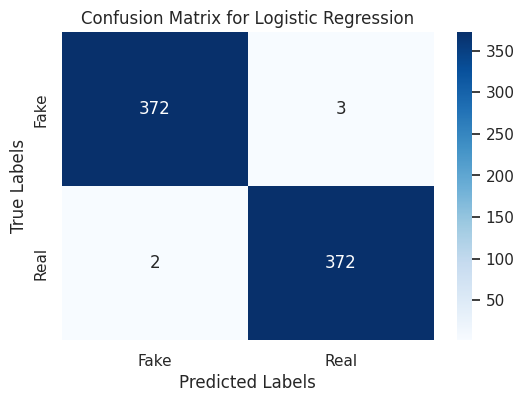

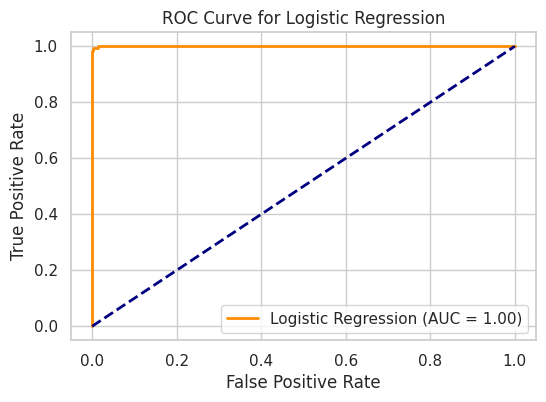

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic Regression Training
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred_logreg = logreg.predict(X_test)

# Calculate accuracy
acc_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {acc_logreg:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_logreg)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# AUC and ROC Curve
y_pred_prob = logreg.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)  # Compute FPR, TPR
roc_auc = auc(fpr, tpr)  # Compute AUC score

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random chance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend(loc="lower right")
plt.show()


Naive Bayes Accuracy: 0.9479


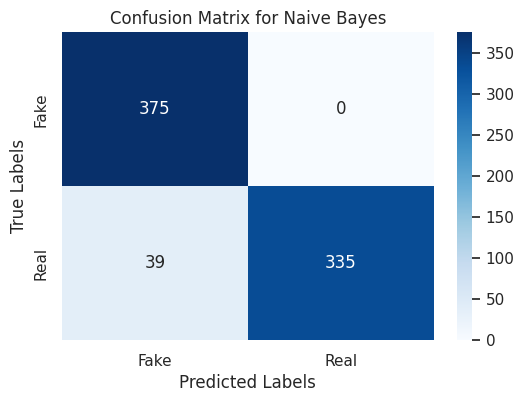

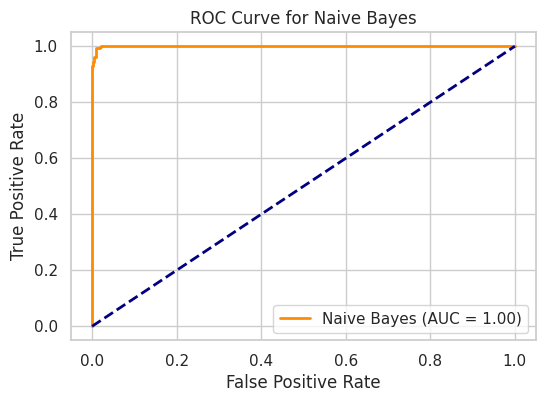

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Multinomial Naive Bayes
nb = MultinomialNB()

# Train the model
nb.fit(X_train, y_train)

# Predict on test set
y_pred_nb = nb.predict(X_test)

# Calculate accuracy
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {acc_nb:.4f}")

# Confusion Matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Naive Bayes")
plt.show()

# AUC and ROC Curve
y_pred_prob_nb = nb.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_prob_nb)  # Compute FPR, TPR
roc_auc_nb = auc(fpr_nb, tpr_nb)  # Compute AUC score

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f"Naive Bayes (AUC = {roc_auc_nb:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random chance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Naive Bayes")
plt.legend(loc="lower right")
plt.show()


Random Forest Accuracy: 0.9960


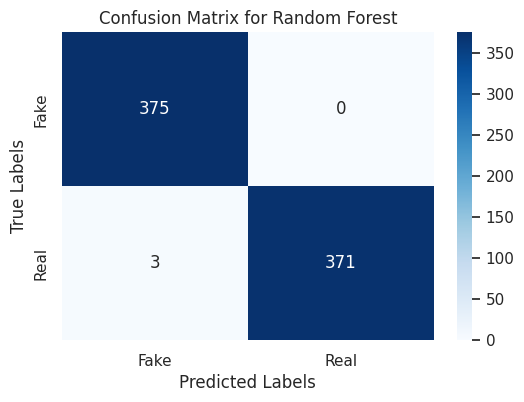

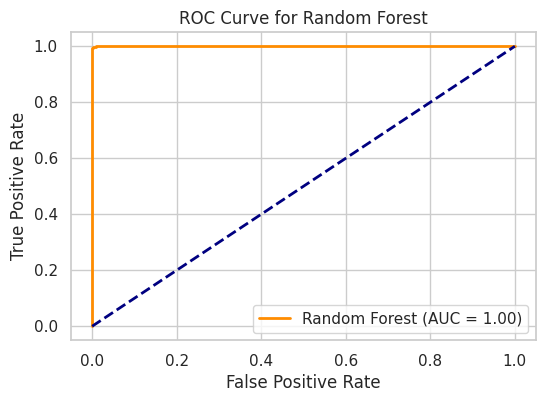

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)

# Calculate accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf:.4f}")

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Random Forest")
plt.show()

# AUC and ROC Curve
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)  # Compute FPR, TPR
roc_auc_rf = auc(fpr_rf, tpr_rf)  # Compute AUC score


plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random chance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest")
plt.legend(loc="lower right")
plt.show()


<ipython-input-44-3e8f503d7c6f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='viridis')


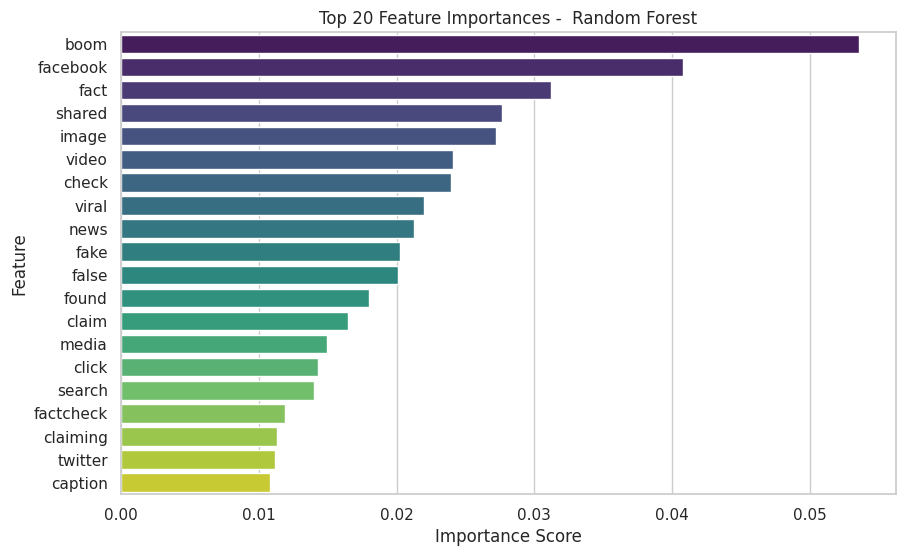

In [ ]:
import numpy as np


feature_importances = best_rf.feature_importances_

feature_names = tfidf_vectorizer.get_feature_names_out()


feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})


feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(20)


plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='viridis')
plt.title('Top 20 Feature Importances -  Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()
